# Transfer Learning  with TensorFlow Part 2: Fine-Tuning

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## Creating helper functions

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-12-28 10:21:50--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8003::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2023-12-28 10:21:51 (14.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Let's get some data

This time we're going to see how we can use the pretrained models within `tf.keras.application`

In [ ]:
# Get 10% of training data of 10 classes of Food101
!wget "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip"

--2023-12-29 05:49:38--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.107.207, 108.177.98.207, 74.125.197.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.107.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  70.0MB/s    in 2.3s    

2023-12-29 05:49:40 (70.0 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
import zipfile

filename = "10_food_classes_10_percent.zip"
zip_ref = zipfile.ZipFile(filename, "r")
zip_ref.extractall()
zip_ref.close()

In [ ]:
import os

dir_path = "./10_food_classes_10_percent"
for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in './10_food_classes_10_percent'.
There are 10 directories and 0 images in './10_food_classes_10_percent/test'.
There are 0 directories and 250 images in './10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in './10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in './10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in './10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in './10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in './10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in './10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in './10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in './10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in './10_foo

In [ ]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [168]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                               image_size=IMG_SIZE,
                                                               label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [169]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [170]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [171]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
    print(images, labels)

tf.Tensor(
[[[[2.19571426e+02 2.26571426e+02 2.32571426e+02]
   [2.25831635e+02 2.33831635e+02 2.36831635e+02]
   [2.27000000e+02 2.35000000e+02 2.38000000e+02]
   ...
   [1.00647995e+02 1.10423500e+02 1.07571404e+02]
   [1.01974487e+02 1.12974487e+02 1.06974487e+02]
   [9.92856827e+01 1.10999962e+02 1.02642822e+02]]

  [[2.18928574e+02 2.25928574e+02 2.31928574e+02]
   [2.26785721e+02 2.34785721e+02 2.37785721e+02]
   [2.28341827e+02 2.36341827e+02 2.39341827e+02]
   ...
   [9.99438553e+01 1.12158142e+02 1.08484627e+02]
   [9.67193756e+01 1.11862236e+02 1.04790802e+02]
   [9.53826218e+01 1.11668335e+02 1.01739761e+02]]

  [[2.17357147e+02 2.24357147e+02 2.30357147e+02]
   [2.25943893e+02 2.33943893e+02 2.36943893e+02]
   [2.29382645e+02 2.37382645e+02 2.40382645e+02]
   ...
   [9.40713882e+01 1.10306114e+02 1.03117325e+02]
   [9.08571472e+01 1.09428574e+02 1.03000000e+02]
   [9.14949265e+01 1.10709213e+02 1.04066353e+02]]

  ...

  [[5.36581917e+01 6.56581879e+01 6.56581879e+01]
   [5

In [172]:
# Create TensorBoard callback (functionized bevause we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to : {log_dir}")
    return tensorboard_callback

In [173]:

# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# OLD
# base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNetV2
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNetV2 inputs don't have to be normalized)
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)


In [174]:
# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# 10. Fit the model (we use less steps for validation so it's faster)
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=int(0.25 * len(test_data_10_percent)),
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])

Saving TensorBoard log files to : transfer_learning/10_percent_feature_extract/20231229-115222
Epoch 1/5
24/24 [==============================] - 96s 4s/step - loss: 1.9372 - accuracy: 0.3933 - val_loss: 1.3726 - val_accuracy: 0.7155
Epoch 2/5
24/24 [==============================] - 84s 4s/step - loss: 1.1679 - accuracy: 0.7480 - val_loss: 0.9292 - val_accuracy: 0.8388
Epoch 3/5
24/24 [==============================] - 78s 3s/step - loss: 0.8614 - accuracy: 0.8147 - val_loss: 0.7395 - val_accuracy: 0.8536
Epoch 4/5
24/24 [==============================] - 84s 4s/step - loss: 0.6971 - accuracy: 0.8520 - val_loss: 0.6580 - val_accuracy: 0.8520
Epoch 5/5
24/24 [==============================] - 84s 4s/step - loss: 0.5975 - accuracy: 0.8733 - val_loss: 0.5759 - val_accuracy: 0.8684


In [ ]:
# Check layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

In [ ]:
import os
model_dir = "models/05_models/"

os.makedirs(model_dir, exist_ok=True)

model_0.save(os.path.join(model_dir, "00_model.keras"))

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./transfer_learning

In [ ]:
model_0.evaluate(test_data_10_percent)

79/79 [==============================] - 144s 2s/step - loss: 0.5714 - accuracy: 0.8584


[0.5714187622070312, 0.8583999872207642]

In [ ]:
base_model.summary()

In [ ]:
model_0.summary()

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()
  plt.grid()

  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()
  plt.grid();

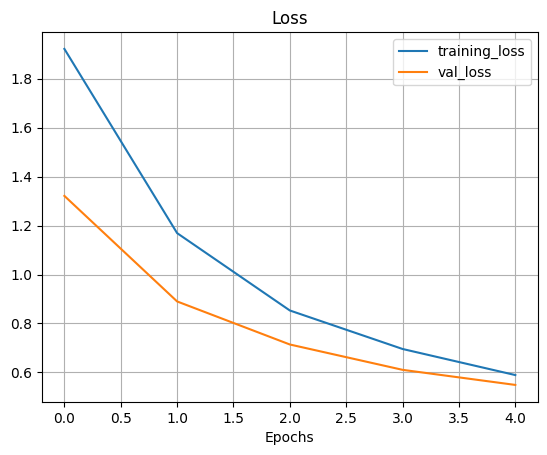

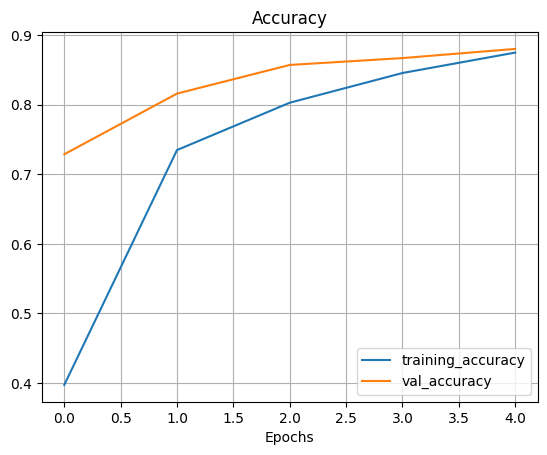

In [ ]:
plot_loss_curves(history_10_percent)

## Getting a feature vector from trained model

In [ ]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}")

# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.26454744]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728497  0.40125778 -1.4145442 ]
   [-0.59318566 -1.6617213   0.33567193]
   [ 0.10815629  0.2347968  -0.56668764]
   [-0.35819843  0.88698626  0.5274477 ]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840445 -0.28855976]]
Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [ ]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840445, -0.28855976]], dtype=float32)>

**Practice:** Try to do the same with the above two cels but this time use `GlobalMaxPool2D` ... and see what happens.

In [ ]:
global_maxpool_tensor = tf.keras.layers.GlobalMaxPool2D()(input_tensor)
print(f"2D global max pooled random tensor:\n {global_maxpool_tensor}")

2D global max pooled random tensor:
 [[0.9058464 1.1603122 1.6994323]]


In [ ]:
global_maxpool_tensor.shape

TensorShape([1, 3])

## Running a series of transfer learning experiments

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10% of the training with data augmentation
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation

## Getting and preprocessing data for model_1

In [ ]:
# Download and unzip data - preprocessed from Food101
!wget "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip"

import zipfile
zip_ref = zipfile.ZipFile("10_food_classes_1_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2023-12-29 05:50:37--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.207, 74.125.135.207, 74.125.142.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   238MB/s    in 0.5s    

2023-12-29 05:50:38 (238 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir_1_percent = "10_food_classes_1_percent/test"

In [ ]:
dir_path = "10_food_classes_1_percent"
for dirpath, dirnames, filenames in os.walk(dir_path):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}")

There are 2 directories and 0 images in '10_food_classes_1_percent
There are 10 directories and 0 images in '10_food_classes_1_percent/test
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger
There are 10 directori

In [ ]:
# Setup data loaders
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE)  # default
test_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir_1_percent,
                                                                          label_mode="categorical",
                                                                          image_size=IMG_SIZE,
                                                                          batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into our models, we can use the layers inside:

* `tf.keras.layers.experimental.prprocessing()`


* Preprocessing of images (augmenting them) happens on the GPU (much faster) rather than on CPU.
* Image data augmentation only happens during training, so  we can still export our whole model and use it elsewhere

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create daa augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescale(1./255)  # Keep for models like ResNet50V2 but EfficientNet's having rescaling build-in
], name="data_augmentation")

### Visualize our data augmentation layer (and see what happens to our data)

Text(0.5, 1.0, 'Augmented random image ramen')

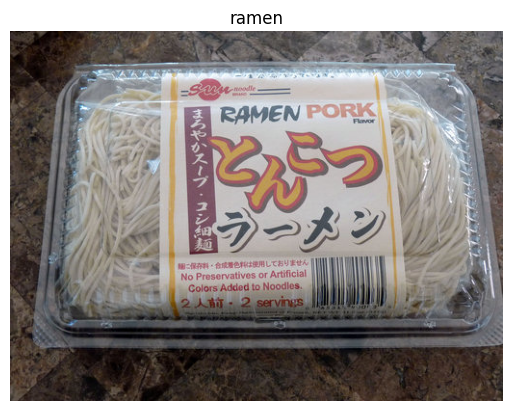

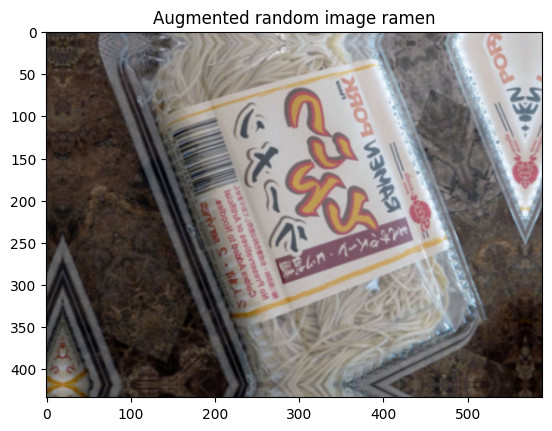

In [ ]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(target_class)
plt.axis(False);

# Now let's plot our augmented random image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image {target_class}")

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [ ]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_shape")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model with inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_1_percent = model_1.fit(train_data_1_percent,
            epochs=5,
            steps_per_epoch=len(train_data_1_percent),
            validation_data=test_data_1_percent,
            validation_steps=int(0.25 * len(test_data_1_percent)),
            callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                   experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to : transfer_learning/1_percent_data_aug/20231228-161008
Epoch 1/5
3/3 [==============================] - 98s 44s/step - loss: 2.4446 - accuracy: 0.0714 - val_loss: 2.2119 - val_accuracy: 0.1941
Epoch 2/5
3/3 [==============================] - 90s 43s/step - loss: 2.1901 - accuracy: 0.2429 - val_loss: 2.0780 - val_accuracy: 0.2895
Epoch 3/5
3/3 [==============================] - 60s 29s/step - loss: 1.9439 - accuracy: 0.3714 - val_loss: 1.9836 - val_accuracy: 0.3635
Epoch 4/5
3/3 [==============================] - 46s 22s/step - loss: 1.8133 - accuracy: 0.4571 - val_loss: 1.8780 - val_accuracy: 0.4227
Epoch 5/5
3/3 [==============================] - 47s 22s/step - loss: 1.5980 - accuracy: 0.6286 - val_loss: 1.7804 - val_accuracy: 0.4836


In [ ]:
# Check iut a model summary
model_1.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_shape (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

In [ ]:
# Evaluate on the full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data_1_percent)
results_1_percent_data_aug

79/79 [==============================] - 168s 2s/step - loss: 1.7897 - accuracy: 0.4828


[1.7897396087646484, 0.4828000068664551]

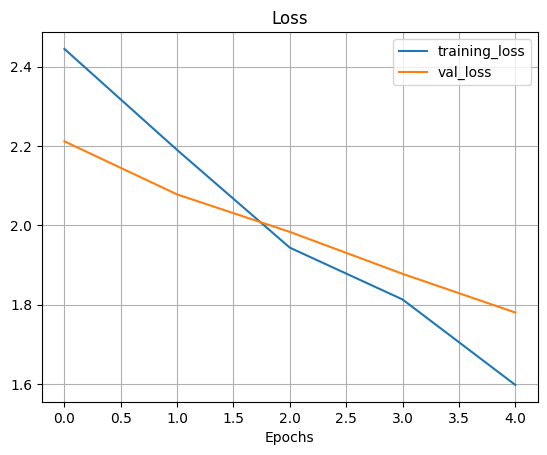

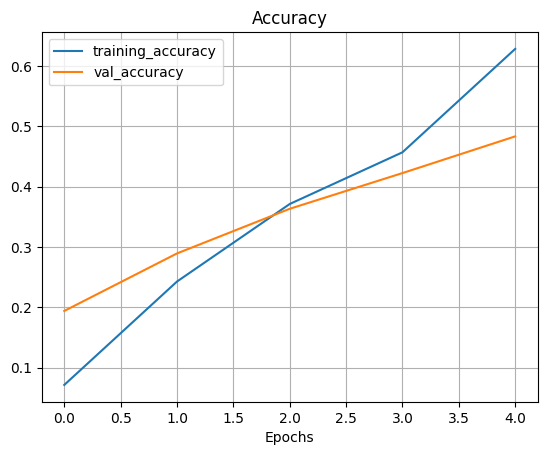

In [ ]:
# How do the model with 1% of the data augmentation loss curves look?
plot_loss_curves(history_1_percent)

## Model 2: Feature extraction transfer learning with 10% of the data with data augmentation

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = keras.Sequential([preprocessing.RandomFlip("horizontal"),
                                      preprocessing.RandomRotation(0.2),
                                      preprocessing.RandomZoom(0.2),
                                      preprocessing.RandomHeight(0.2),
                                      preprocessing.RandomWidth(0.2),
                                      ], name="data_augmentation")

In [ ]:
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_shape")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

model_2 = keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

16705208/16705208 [==============================] - 0s 0us/step


### Createing a ModelCheckpoint callback

In [ ]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weghts/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weight_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch",  # save every epoch
                                                         verbose=1)

### Fit model 2 passing in  the ModelCheckpoint callback

In [ ]:
initial_epochs = 5

In [82]:
# Fit the model saving checkpoints every epoch
history_10_percent_aug = model_2.fit(train_data_10_percent,
                              epochs=5,
                              steps_per_epoch=len(train_data_10_percent),
                              validation_data=test_data_10_percent,
                              validation_steps=int(0.25 * len(test_data_10_percent)),
                              callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                     experiment_name="10_percent_data_aug"),
                                         checkpoint_callback])

Saving TensorBoard log files to : transfer_learning/10_percent_data_aug/20231229-085332
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 0.6586 - accuracy: 0.8280
Epoch 1: saving model to ten_percent_model_checkpoints_weghts/checkpoint.ckpt
24/24 [==============================] - 196s 8s/step - loss: 0.6586 - accuracy: 0.8280 - val_loss: 0.5712 - val_accuracy: 0.8470
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 0.5905 - accuracy: 0.8560
Epoch 2: saving model to ten_percent_model_checkpoints_weghts/checkpoint.ckpt
24/24 [==============================] - 180s 8s/step - loss: 0.5905 - accuracy: 0.8560 - val_loss: 0.5302 - val_accuracy: 0.8454
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.5573 - accuracy: 0.8480
Epoch 3: saving model to ten_percent_model_checkpoints_weghts/checkpoint.ckpt
24/24 [==============================] - 179s 8s/step - loss: 0.5573 - accuracy: 0.8480 - val_loss: 0.5033 - val_accuracy: 0.8618
Epoch 4/5

In [88]:
import pickle

with open('history_10_percent_aug.pkl', 'wb') as handle:
    pickle.dump(history_10_percent_aug, handle)

In [89]:
import pickle

with open('history_10_percent_aug.pkl', 'rb') as file:
  history_10_percent_aug_loaded = pickle.load(file)

In [ ]:
plot_loss_curves(history_10_percent_aug_loaded)

In [ ]:
model_0.evaluate(test_data_10_percent)

79/79 [==============================] - 130s 2s/step - loss: 0.5714 - accuracy: 0.8584


[0.5714185833930969, 0.8583999872207642]

In [ ]:
results_10_percent_data_aug = model_2.evaluate(test_data_10_percent)

79/79 [==============================] - 171s 2s/step - loss: 0.4860 - accuracy: 0.8568


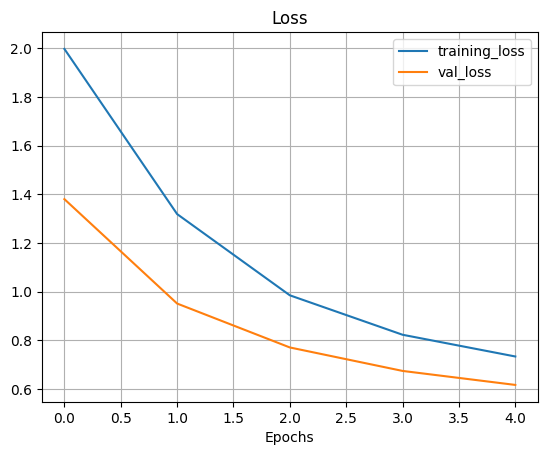

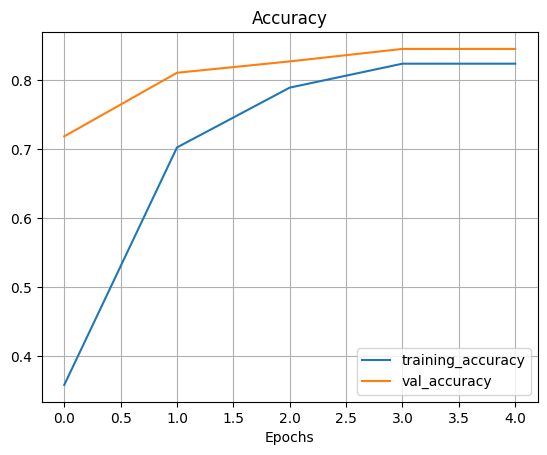

In [ ]:
plot_loss_curves(history_10_percent_aug)

### Loading in checkpointed weights

In [102]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [103]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data_10_percent)

79/79 [==============================] - 221s 3s/step - loss: 0.4957 - accuracy: 0.8544


In [105]:
results_10_percent_data_aug == loaded_weights_model_results

NameError: ignored

In [ ]:
# Check to see if loaded model results  are very close to our previous non-loaded model results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [ ]:
# Check the difference between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[1.49011612e-07 0.00000000e+00]


In [ ]:
model_0.save('model_0.keras')

In [ ]:
model_1.save('model_1.keras')

In [ ]:
model_2.save('model_2.keras')

In [ ]:
from tensorflow.keras.models import load_model

model_0_loaded = load_model('model_0.keras')
model_1_loaded = load_model('model_1.keras')
model_2_loaded = load_model('model_2.keras')

## Model 3: Fine-tuning an existing model on 10% of the data

In [ ]:
model_2_base_model = model_2_loaded.layers[2]
model_2_base_model.name

'efficientnetb0'

In [ ]:

# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(model_2_base_model.layers):
  print(layer_number, layer.name, layer.trainable)

In [ ]:
# How many trainable variables are in our base model?
print(len(model_2_base_model.trainable_variables))

0


In [ ]:

# Make all the layers in model_2_base_model trainable
model_2_base_model.trainable = True

# Freeze all layers except for the last 10
for layer in model_2_base_model.layers[:-10]:
  layer.trainable = False

# Recompile the whole model (always recompile after any adjustments to a model)
model_2_loaded.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                metrics=["accuracy"])

In [ ]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(model_2_base_model.layers):
  print(layer_number, layer.name, layer.trainable)

In [ ]:
print(len(model_2_base_model.layers))

238


In [ ]:
print(len(model_2_base_model.trainable_variables))

10


In [94]:
fine_tune_epochs = initial_epochs + 5
history_fine_10_percent_data_aug = model_2_loaded.fit(train_data_10_percent,
                                                    epochs=fine_tune_epochs,
                                                    validation_data=test_data_10_percent,
                                                    validation_steps=int(0.25 * len(test_data_10_percent)),
                                                    initial_epoch=history_10_percent_aug_loaded.epoch[-1],  # start trianing from previous last epoch
                                                    callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                          experiment_name="10_percent_fine_tune_last_10_percent")])

Saving TensorBoard log files to : transfer_learning/10_percent_fine_tune_last_10_percent/20231229-091345
Epoch 5/10
24/24 [==============================] - 162s 6s/step - loss: 0.4222 - accuracy: 0.8813 - val_loss: 0.4138 - val_accuracy: 0.8536
Epoch 6/10
24/24 [==============================] - 146s 6s/step - loss: 0.3628 - accuracy: 0.8947 - val_loss: 0.3778 - val_accuracy: 0.8717
Epoch 7/10
24/24 [==============================] - 149s 6s/step - loss: 0.3144 - accuracy: 0.9053 - val_loss: 0.3910 - val_accuracy: 0.8602
Epoch 8/10
24/24 [==============================] - 146s 6s/step - loss: 0.2875 - accuracy: 0.9107 - val_loss: 0.4188 - val_accuracy: 0.8651
Epoch 9/10
24/24 [==============================] - 120s 5s/step - loss: 0.2391 - accuracy: 0.9240 - val_loss: 0.3803 - val_accuracy: 0.8635
Epoch 10/10
24/24 [==============================] - 149s 6s/step - loss: 0.2097 - accuracy: 0.9480 - val_loss: 0.4222 - val_accuracy: 0.8602


In [95]:
import pickle

with open('history_fine_10_percent_data_aug.pkl', 'wb') as handle:
    pickle.dump(history_fine_10_percent_data_aug, handle)

In [98]:
results_fine_tune_10_percent = model_2_loaded.evaluate(test_data_10_percent)

79/79 [==============================] - 195s 2s/step - loss: 0.4116 - accuracy: 0.8668


In [107]:
results_10_percent_data_aug = model_2_loaded.evaluate(test_data_10_percent)
results_10_percent_data_aug

79/79 [==============================] - 257s 3s/step - loss: 0.4116 - accuracy: 0.8668


[0.411634236574173, 0.8668000102043152]

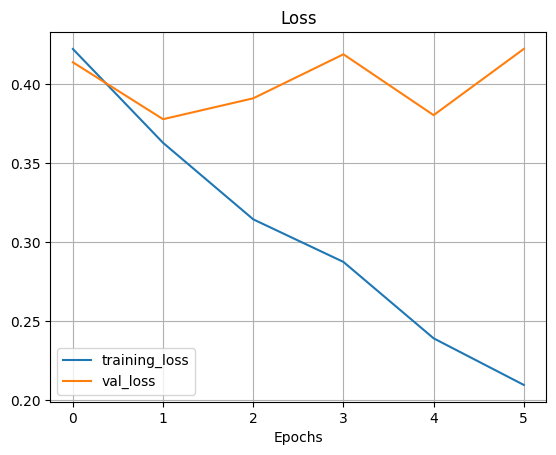

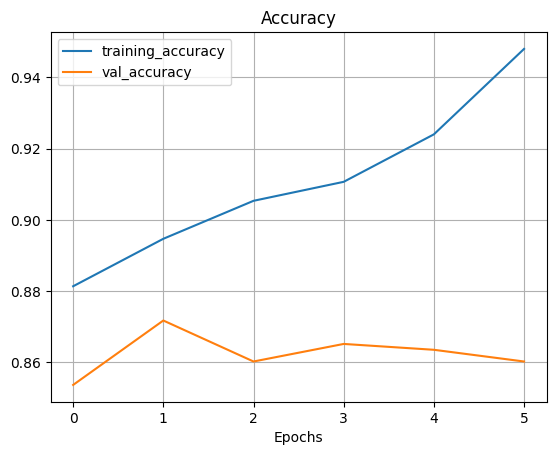

In [108]:
plot_loss_curves(history_fine_10_percent_data_aug)

### Let's create a function works great with modls which have only beet fit once, however, we want something to compare one series of running `fit`

In [112]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
11
[0.828000009059906, 0.8560000061988831, 0.8479999899864197, 0.8653333187103271, 0.8840000033378601, 0.8813333511352539, 0.8946666717529297, 0.9053333401679993, 0.9106666445732117, 0.9240000247955322, 0.9480000138282776]


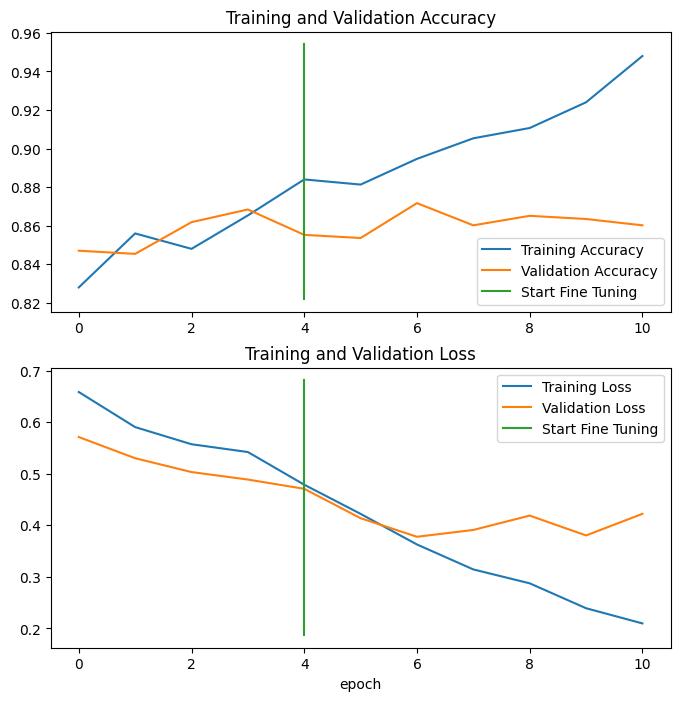

In [113]:
compare_historys(history_10_percent_aug,
                 history_fine_10_percent_data_aug,
                 initial_epochs=5)

In [114]:
!wget "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip"

import zipfile
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2023-12-29 10:30:17--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.207, 74.125.195.207, 172.253.117.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  65.7MB/s    in 9.6s    

2023-12-29 10:30:27 (51.6 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [115]:
train_dir_100_percent = "10_food_classes_all_data/train"
test_dir_100_percent = "10_food_classes_all_data/test"

In [116]:
import os

dir_path = "10_food_classes_all_data"
for dirpath, dirnames, filenames in os.walk(dir_path):
  print(f"There are {len(dirnames)} directoreis and {len(filenames)} images in '{dirpath}")

There are 2 directoreis and 0 images in '10_food_classes_all_data
There are 10 directoreis and 0 images in '10_food_classes_all_data/test
There are 0 directoreis and 250 images in '10_food_classes_all_data/test/sushi
There are 0 directoreis and 250 images in '10_food_classes_all_data/test/fried_rice
There are 0 directoreis and 250 images in '10_food_classes_all_data/test/pizza
There are 0 directoreis and 250 images in '10_food_classes_all_data/test/ice_cream
There are 0 directoreis and 250 images in '10_food_classes_all_data/test/chicken_wings
There are 0 directoreis and 250 images in '10_food_classes_all_data/test/grilled_salmon
There are 0 directoreis and 250 images in '10_food_classes_all_data/test/chicken_curry
There are 0 directoreis and 250 images in '10_food_classes_all_data/test/ramen
There are 0 directoreis and 250 images in '10_food_classes_all_data/test/steak
There are 0 directoreis and 250 images in '10_food_classes_all_data/test/hamburger
There are 10 directoreis and 0 ima

In [149]:

# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

# Note: this is the same test dataset we've been using for the previous modelling experiments
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### To train a fine-tuning model (model_4) we need to revert model_2 back to its feature extraction weights

In [150]:

# Evaluate model (this is the fine-tuned 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 221s 3s/step - loss: 0.4957 - accuracy: 0.8544


[0.49570396542549133, 0.8543999791145325]

In [151]:
results_fine_tune_10_percent

[0.411634236574173, 0.8668000102043152]

In [157]:
def create_base_model(input_shape: tuple[int, int, int] = (224, 224, 3),
                      output_shape: int = 10,
                      learning_rate: float = 0.001,
                      training: bool = False) -> tf.keras.Model:
    """
    Create a model based on EfficientNetV2B0 with built-in data augmentation.

    Parameters:
    - input_shape (tuple): Expected shape of input images. Default is (224, 224, 3).
    - output_shape (int): Number of classes for the output layer. Default is 10.
    - learning_rate (float): Learning rate for the Adam optimizer. Default is 0.001.
    - training (bool): Whether the base model is trainable. Default is False.

    Returns:
    - tf.keras.Model: The compiled model with specified input and output settings.
    """

    # Create base model
    base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
    base_model.trainable = training

    # Setup model input and outputs with data augmentation built-in
    inputs = layers.Input(shape=input_shape, name="input_layer")
    x = data_augmentation(inputs)
    x = base_model(x, training=False)  # pass augmented images to base model but keep it in inference mode
    x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
    outputs = layers.Dense(units=output_shape, activation="softmax", name="output_layer")(x)
    model = tf.keras.Model(inputs, outputs)

    # Compile model
    model.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])

    return model

# Create an instance of model_2 with our new function
model_2 = create_base_model()

In [161]:
# Create a new instance of model_2 for Experiment 4
model_2 = create_base_model(learning_rate=0.0001) # 10x lower learning rate for fine-tuning

In [166]:
# Load previously checkpointed weights
model_2.load_weights(checkpoint_path)

ValueError: ignored

In [167]:
print(len(model_2.trainable_variables))

2


In [ ]:
# After loading the weights, this should have gone down (no fine-tuning)
model_2.evaluate(test_data)

In [142]:
# Check which layers are tunable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_shape True
1 data_augmentation True
2 efficientnetb0 False
3 global_average_pooling_layer True
4 output_layer True


In [145]:

# Unfreeze the top 10 layers in model_2's base_model
model_2_base_model = model_2.layers[2]
model_2_base_model.trainable = True

# Freeze all layers except for the last 10
for layer in model_2_base_model.layers[:-10]:
  layer.trainable = False


In [ ]:
# Let's drill into our base_model (efficientnetb0) and see what layers are trainable
for layer_number, layer in enumerate(model_2_base_model.layers):
  print(layer_number, layer.name, layer.trainable)

In [148]:
# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [179]:
history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           initial_epoch=history_10_percent_aug.epoch[-1],
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                   experiment_name="full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to : transfer_learning/full_10_classes_fine_tune_last_10/20231229-122656
Epoch 5/10
24/24 [==============================] - 94s 4s/step - loss: 0.8806 - accuracy: 0.7680 - val_loss: 0.6931 - val_accuracy: 0.7944
Epoch 6/10
24/24 [==============================] - 90s 4s/step - loss: 0.7610 - accuracy: 0.8093 - val_loss: 0.6332 - val_accuracy: 0.8076
Epoch 7/10
24/24 [==============================] - 91s 4s/step - loss: 0.6893 - accuracy: 0.8120 - val_loss: 0.5535 - val_accuracy: 0.8289
Epoch 8/10
24/24 [==============================] - 92s 4s/step - loss: 0.6399 - accuracy: 0.8293 - val_loss: 0.5871 - val_accuracy: 0.8273
Epoch 9/10
24/24 [==============================] - 91s 4s/step - loss: 0.6105 - accuracy: 0.8320 - val_loss: 0.5644 - val_accuracy: 0.8240
Epoch 10/10
24/24 [==============================] - 93s 4s/step - loss: 0.5604 - accuracy: 0.8493 - val_loss: 0.5340 - val_accuracy: 0.8322


In [181]:
results_fine_tune_full_data = model_2.evaluate(test_data)

79/79 [==============================] - 168s 2s/step - loss: 0.5117 - accuracy: 0.8420


In [182]:
results_fine_tune_10_percent

[0.411634236574173, 0.8668000102043152]

5
11
[0.828000009059906, 0.8560000061988831, 0.8479999899864197, 0.8653333187103271, 0.8840000033378601, 0.7680000066757202, 0.809333324432373, 0.8119999766349792, 0.8293333053588867, 0.8320000171661377, 0.8493333458900452]


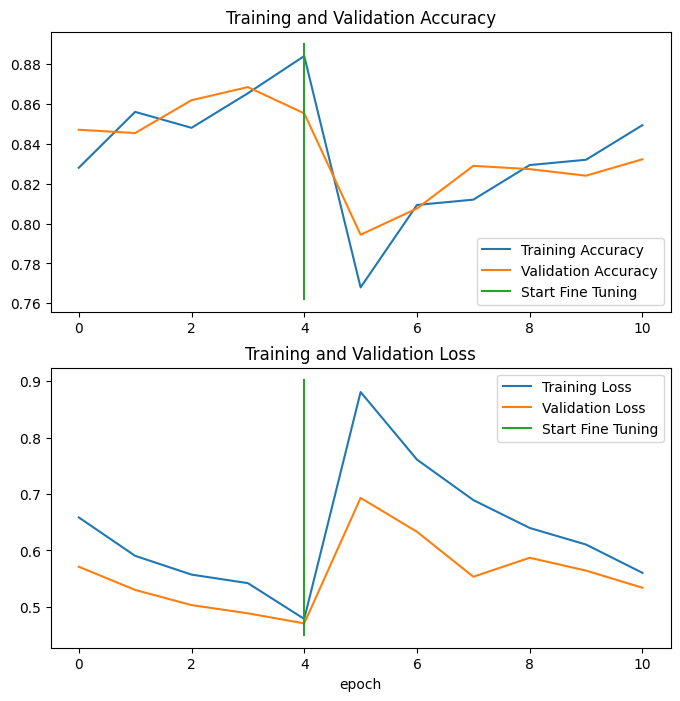

In [187]:
compare_historys(original_history=history_10_percent_aug,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)

## Viewing our experiment data on TensorBoard

In [197]:
%tensorboard --logdir ./transfer_learning

ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
2023-12-29 13:13:11.743781: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-29 13:13:11.743866: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-29 13:13:11.745275: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-29 13:13:12.979301: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--logdir_spec PATH_SPEC] [--host ADDR]
                   [--bind_all] [--port PORT] [--reuse_port BOOL] [--load_f

In [212]:
def load_and_prep_image(filename, img_shape=224):
    # Read in target file (an image)
    img = tf.io.read_file(filename)

    # Decode the read file into a tensor & ensure 3 colour channels (assuming it's a JPEG image)
    img = tf.image.decode_jpeg(img, channels=3)

    # Resize the image (to the same size our model was trained on)
    img = tf.image.resize(img, size=[img_shape, img_shape])

    # Rescale the image (get all values between 0 and 1)
    img = img / 255.0
    return img

In [253]:
import os
def extract_folder_name(filepath):
  components = filepath.split(os.path.sep)

  train_index = components.index("train")

  folder_name = components[train_index + 1]

  return folder_name

In [254]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  pred_class = class_names[int(tf.round(pred)[0][0])]

  folder_name = extract_folder_name(filename)

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {folder_name}")
  plt.axis(False);

In [255]:
# target_class = random.choice(train_data_1_percent.class_names)
# target_dir = "10_food_classes_1_percent/train/" + target_class
# random_image = random.choice(os.listdir(target_dir))
# random_image_path = target_dir + "/" + random_image
train_data_10_classes_full.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

Randomly chosen class: steak
Randomly chosen image: 2549316.jpg
1/1 [==============================] - 0s 77ms/step


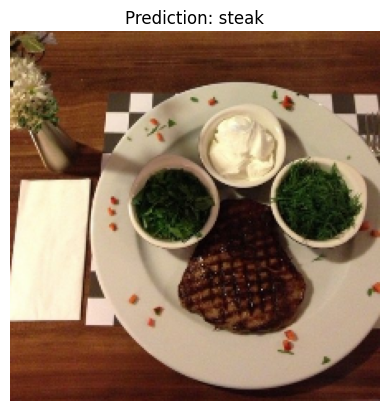

In [259]:
import os
import random
import matplotlib.pyplot as plt

random_folder = random.choice(train_data_10_classes_full.class_names)
target_dir = os.path.join("10_food_classes_all_data/train", random_folder)
random_image = random.choice(os.listdir(target_dir))
random_image_path = os.path.join(target_dir, random_image)

print("Randomly chosen class:", random_folder)
print("Randomly chosen image:", random_image)

pred_and_plot(model_2, random_image_path, random_folder)